In [107]:
# import pandas as pd

# file_path_1 = "/home/alex/dev/AiLearning/DataSetStore/text_classification_2/positive.csv"
# pos_df = pd.read_csv(file_path_1, sep=';', usecols=[3], names=['text'])
# pos_df ['label'] = 1

# file_path_2 = "/home/alex/dev/AiLearning/DataSetStore/text_classification_2/negative.csv"
# neg_df = pd.read_csv(file_path_1, sep=';', usecols=[3], names=['text'])
# neg_df ['label'] = 0

# df = pos_df._append(neg_df)
# df['label'].value_counts()

#df['text'][0:1].item()

In [4]:
#pip install natasha
# ************************************************************************
# https://habr.com/ru/articles/516098/

In [108]:
from natasha import Doc, MorphVocab, Segmenter, NewsEmbedding, NewsMorphTagger

segmenter = Segmenter()
morph_tagger = NewsMorphTagger(NewsEmbedding())
morph_vocab = MorphVocab()

def make_text_tokens(text,filter_set,verbose=False):
    doc = Doc(text)
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)

    selected_tokens=[]
    for token in doc.tokens:
        token.lemmatize(morph_vocab)
        if verbose: print ("i: ", token)
        if token.pos in filter_set:
            if verbose: print ("o: ", token)
            selected_tokens.append(token.lemma)
    if len(selected_tokens)==0:
        selected_tokens.append("ошибка")
    return selected_tokens

#make_text_tokens(text=df['text'][64730:64731].item(),filter_set=("ADV","PRON","VERB","CCONJ","NOUN","PUNCT"),verbose=True)

In [109]:
# from collections import Counter

# corpus=[]
# for text in df.sample(frac=1)['text'][0:100]:
#     for selected_token in make_text_tokens(text,
#                                            filter_set=("ADV","PRON","VERB","CCONJ","NOUN","PUNCT")):
#         corpus.append(selected_token)

# print ("Corpus length: ",len(corpus))
# corpus


In [120]:
# freq_dict = Counter(corpus)

# #freq_dict.items()
# # sorting by the second element in the reverse order:
# freq_items_sorted= sorted(freq_dict.items(), key=lambda x: -x[1])

# freq_items_sorted[:100]

1) Reading text data. Selecting computational range

In [102]:
import pandas as pd

file_path_1 = "/home/alex/dev/AiLearning/DataSetStore/text_classification_2/positive.csv"
pos_df = pd.read_csv(file_path_1, sep=';', usecols=[3], names=['text'])
pos_df ['label'] = 1

file_path_2 = "/home/alex/dev/AiLearning/DataSetStore/text_classification_2/negative.csv"
neg_df = pd.read_csv(file_path_1, sep=';', usecols=[3], names=['text'])
neg_df ['label'] = 0

df = pos_df._append(neg_df)

In [103]:
from sklearn.model_selection import train_test_split

SIZE=10000
random_copy = df.sample(frac=1)[0:SIZE]

#tokenized_text = random_copy['text']

tokenized_text = random_copy['text'].apply(lambda txt:\
                                          " ".join(make_text_tokens(txt,
                                                                    filter_set=("ADV","PRON","VERB","CCONJ","NOUN","PUNCT"))))

x_train, x_test, y_train, y_test = train_test_split(tokenized_text, random_copy['label'])

print (len(x_train),len(x_test))
tokenized_text.head()

7500 2500


39845    : / / . / это утро чуствовать , паста спирт =)))
38988      вернуться и рассказать , круг ад я проходить )
8353                искать тот , кто нежность ) : / / . /
22548                  , а я бадж выдать стековерфлоу : d
45423     , очень день сегодня , что-то я подсказывать :)
Name: text, dtype: object

2) Counting corpus size and ratio

In [110]:
from collections import Counter

corpus=[]
for text in x_train:
    for selected_token in text.split(" "):
        corpus.append(selected_token)

print ("Corpus length: ",len(corpus))
# corpus

freq_dict = Counter(corpus)

#freq_dict.items()
# sorting by the second element in the reverse order:
freq_items_sorted= sorted(freq_dict.items(), key=lambda x: -x[1])



Corpus length:  92732


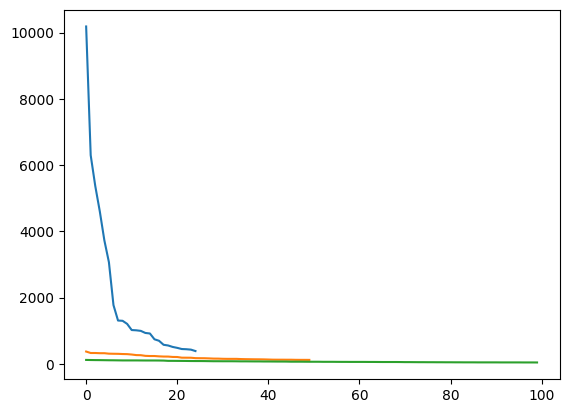

In [111]:
import matplotlib.pyplot as plt
%matplotlib inline
first_25 = [freq for word, freq in freq_items_sorted[:25]]
next_50 = [freq for word, freq in freq_items_sorted[25:75]]
next_100 = [freq for word, freq in freq_items_sorted[75:175]]
plt.plot(first_25)
plt.plot(next_50)
plt.plot(next_100)
plt.show()

In [114]:
first_25 = [word for word, freq in freq_items_sorted[:25]]
next_50 = [word for word, freq in freq_items_sorted[25:75]]
next_100 = [word for word, freq in freq_items_sorted[75:175]]
first_25

[')',
 ',',
 ':',
 '/',
 '.',
 'я',
 'и',
 '!',
 ':)',
 'ты',
 'd',
 'а',
 '?',
 '"',
 '-',
 '#',
 'это',
 'весь',
 '...',
 'так',
 'мы',
 'он',
 'что',
 'но',
 '@']

3. Training with different vocabularies (top25, 50 , 75 and all)

In [115]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report

for vocabulary in (first_25,next_50,next_100):
    vec = CountVectorizer(ngram_range=(1, 2),vocabulary=vocabulary)
    bow = vec.fit_transform(x_train)

    clf = LogisticRegression(random_state=42,max_iter=100000)
    clf.fit(bow, y_train)
    
    pred = clf.predict(vec.transform(x_test))
    print("  --> Vocabulary: {}\n".format(len(vocabulary)),classification_report(pred, y_test))


  --> Vocabulary: 25
               precision    recall  f1-score   support

           0       0.83      0.50      0.63      2054
           1       0.18      0.51      0.27       446

    accuracy                           0.51      2500
   macro avg       0.50      0.51      0.45      2500
weighted avg       0.71      0.51      0.56      2500

  --> Vocabulary: 50
               precision    recall  f1-score   support

           0       0.74      0.50      0.60      1857
           1       0.26      0.50      0.34       643

    accuracy                           0.50      2500
   macro avg       0.50      0.50      0.47      2500
weighted avg       0.62      0.50      0.53      2500

  --> Vocabulary: 100
               precision    recall  f1-score   support

           0       0.78      0.50      0.61      1950
           1       0.22      0.49      0.30       550

    accuracy                           0.50      2500
   macro avg       0.50      0.50      0.45      2500
weighte

In [116]:
vec = CountVectorizer(ngram_range=(1, 2))
bow = vec.fit_transform(x_train)

clf = LogisticRegression(random_state=42,max_iter=100000)
clf.fit(bow, y_train)
    
pred = clf.predict(vec.transform(x_test))
print("  --> Full vocabulary:\n",classification_report(pred, y_test))

  --> Full vocabulary:
               precision    recall  f1-score   support

           0       0.52      0.49      0.50      1323
           1       0.46      0.49      0.47      1177

    accuracy                           0.49      2500
   macro avg       0.49      0.49      0.49      2500
weighted avg       0.49      0.49      0.49      2500



4. Searching best features

In [119]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

vec = CountVectorizer(ngram_range=(1, 2))
bow = vec.fit_transform(x_train)
fs = SelectKBest(score_func=f_regression, k=2)
features = fs.fit_transform(bow, y_train)
print(features)


  (970, 0)	1
  (1252, 0)	1
  (1458, 1)	1
  (1755, 1)	1
  (1823, 1)	1
  (2305, 1)	1
  (2925, 0)	1
  (3109, 1)	1
  (3222, 1)	1
  (3261, 0)	1
  (3410, 0)	1
  (3511, 1)	1
  (4000, 1)	1
  (4041, 0)	1
  (4164, 0)	1
  (4727, 0)	1
  (4801, 1)	1
  (4807, 0)	1
  (4816, 1)	1
  (5006, 0)	1
  (5044, 1)	1
  (5170, 0)	1
  (5252, 1)	1
  (5632, 0)	1
  (5739, 0)	1


In [95]:
list(vec.vocabulary_.items())[:10]

[('кстати', 13570),
 ('вы', 4513),
 ('песня', 23074),
 ('электричество', 40900),
 ('кстати вы', 13574),
 ('вы песня', 4627),
 ('песня электричество', 23128),
 ('час', 39604),
 ('вести', 2567),
 ('настолько', 17826)]

In [98]:
clf = LogisticRegression(random_state=42,max_iter=100000)
clf.fit(bow, y_train)

LogisticRegression(max_iter=100000, random_state=42)

In [99]:
from sklearn.metrics import classification_report
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

           0       0.50      0.50      0.50      1289
           1       0.47      0.48      0.48      1211

    accuracy                           0.49      2500
   macro avg       0.49      0.49      0.49      2500
weighted avg       0.49      0.49      0.49      2500

